# Imports and functions

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score


2024-01-27 20:15:33.248406: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-27 20:15:33.293045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 20:15:33.293084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 20:15:33.294348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 20:15:33.301517: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import torchvision
import engine
import engine_boosted
import engine_boosted_multi
import helper_functions

In [3]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
from collections import deque  # Import deque for early stopping
import warnings

# Suppress the specific UserWarning related to y_pred and y_true class mismatch
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

In [4]:
from sklearn.metrics import balanced_accuracy_score

# Function to calculate balanced accuracy using sklearn
def balanced_accuracy(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 100

In [5]:
# Function to perform one-hot encoding for DNA sequences
def one_hot_encode(sequence):
    encoding = {'A': [1, 0, 0, 0], 'T': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'C': [0, 0, 0, 1]}
    one_hot_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence]
    return np.array(one_hot_sequence)

In [6]:
kernel = {
    'ATF2': [10] ,
    'ATF3' : [10] ,
    'CEBPB' : [10] ,
    'CREB1' : [8] ,
    'CTCF' : [15] ,
    'E2F4' : [13] ,
    'EGR1' : [10] ,
    'EFL1' : [9] ,
    'ELK1' : [9] ,
    'FOS' : [8] ,
    'FOXA1' : [8] ,
    'GABPA' : [10] ,
    'JUN' : [14] ,
    'JUND' : [11] ,
    'MAFK' : [10] ,
    'MAX' : [6] ,
    'MAZ' : [8] ,
    'MXI1' : [6] ,
    'MYC' : [8] ,
    'NRF1' : [11] ,
    'RELA' : [10] ,
    'REST' : [20] ,
    'RFX5' : [14] ,
    'SP1' : [9] ,
    'SRF' : [16] ,
    'TCF7L2' : [9] ,
    'TCF12' : [7] ,
    'TEAD4' : [8] ,
    'USF1' : [10] ,
    'USF2' : [10] ,
    'YY1' : [12] ,
    'ZBTB33' : [10] ,
    'ZNF274' : [12]
}

In [7]:
tf_class = {
    'ATF2': [0] ,
    'ATF3' : [1] ,
    'CEBPB' : [2] ,
    'CREB1' : [3] ,
    'CTCF' : [4] ,
    'E2F4' : [5] ,
    'EGR1' : [6] ,
    'EFL1' : [7],
    'ELK1' : [8],
    'FOS' : [9] ,
    'FOXA1' : [10] ,
    'GABPA' : [11] ,
    'JUN' : [12] ,
    'JUND' : [13] ,
    'MAFK' : [14] ,
    'MAX' : [15] ,
    'MAZ' : [16] ,
    'MXI1' : [17] ,
    'MYC' : [18] ,
    'NRF1' : [19] ,
    'RELA' : [20] ,
    'REST' : [21] ,
    'RFX5' : [22] ,
    'SP1' : [23] ,
    'SRF' : [24] ,
    'TCF7L2' : [25] ,
    'TCF12' : [26] ,
    'TEAD4' : [27] ,
    'USF1' : [28] ,
    'USF2' : [29] ,
    'YY1' : [30] ,
    'ZBTB33' : [31] ,
    'ZNF274' : [32]
}

# Set up device agnostic code

In [8]:
import torch
from torch import nn
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
import pandas as pd

# Read the list of TFs from the file
tf_list_path = '/mnt/raid1/thalassini/home/Downloads/target_names_6.txt'
with open(tf_list_path, 'r') as file:
    tf_list = file.read().splitlines()

# Define the directory where the CSV files for each TF are located
base_directory = '/mnt/raid1/thalassini/home/filtered_fimo_200b_balanced/'

# Combine data for each TF and write to a single CSV file
for tf in tf_list:
    file_path = f'{base_directory}{tf.upper()}/datasets/data.csv'
    
    try:
        df = pd.read_csv(file_path)
        
        # Add a column to identify the TF
        df['TF'] = tf
        
        # Append data to the master DataFrame or create it if it doesn't exist
        if 'master_df' in locals():
            master_df = pd.concat([master_df, df], ignore_index=True)
        else:
            master_df = df
    except FileNotFoundError:
        print(f"File not found for TF: {tf}")

# Save the combined DataFrame to a new CSV file
output_csv_path = '/mnt/raid1/thalassini/home/tf_data/combined_6_data.csv'
master_df.to_csv(output_csv_path, index=False)

print(f"Combined data saved to {output_csv_path}")


File not found for TF: RCOR1
Combined data saved to /mnt/raid1/thalassini/home/tf_data/combined_6_data.csv


In [10]:
master_df

,data,class,TF
0,CTCCTTTTTCCCCCTCTGCCACAACCTCTAAATACTGAGGGCCCCA...,1,ATF2
1,TATAGCAATCTGAATCCTTGTGCTAAACTTAATTGTCGTTGTCGTC...,1,ATF2
2,AAAACCAAAACAAGAAGTCGGTCTCCTCTTTTTATATAATAGTTTA...,1,ATF2
3,TTAGGTCATGCACACTGAACTGAAACTGAGATGAATGACATCATCA...,1,ATF2
4,GAACAGAGGCTCAGGCAGCTGAAGTAACGTGCCTAAGGTCACATGG...,1,ATF2
...,...,...,...
1270042,TCATACAGGTGAGAAACCCTACAAATGTAATGAGTGTGAAAAAACC...,0,ZNF274
1270043,ATTACACTTTCAAGGTTTCTCTCCACTATGAAGTCTATGATGGTAT...,0,ZNF274
1270044,TTACATTTGTAAGGCTTCTCTCCAGTATGGATGACCTGATGGGTAG...,0,ZNF274
1270045,TTCATACTGGAGAGAAACCCTACAAATGCAAAGAATGTTGCAAAGC...,0,ZNF274


In [11]:
# Map tf_class to tf column
df['TF'] = df['TF'].map(tf_class).apply(lambda x: x[0])

df

,data,class,TF
0,AGGGCAGTTCCCAATTACCCAAAGGGATCTTGAGGTTCAGAGACAT...,1,32
1,ACACTGGAGAGAAACCCTATGAGTGTAAGCAATGTGGGAAAGCCTT...,1,32
2,GCTGACATTTATAGGGTTTCTCTTCTGTGTGAGTTTTTTCATGAAT...,1,32
3,TTTTTACATTTATAGGGCTTTTCTCCAGTATGAGTTTTTTTATGCT...,1,32
4,TTTTTACATTTATAGGGCTTTTCTCCAGTATGAGTTTTTTTATGCT...,1,32
...,...,...,...
6445,TCATACAGGTGAGAAACCCTACAAATGTAATGAGTGTGAAAAAACC...,0,32
6446,ATTACACTTTCAAGGTTTCTCTCCACTATGAAGTCTATGATGGTAT...,0,32
6447,TTACATTTGTAAGGCTTCTCTCCAGTATGGATGACCTGATGGGTAG...,0,32
6448,TTCATACTGGAGAGAAACCCTACAAATGCAAAGAATGTTGCAAAGC...,0,32


# Sequence length inspection and normalization

Max length:200, Min length: 200


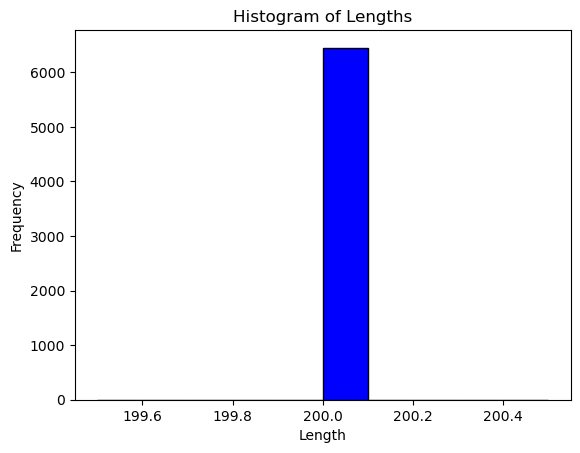

In [12]:
lengths= [len(item) for item in df['data']] 
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(lengths, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Find the maximum length of sequences
#min_length = min(len(seq) for seq in df['data'])
limit=200


# Pad or cut sequences to ensure they all have the same length
cut_sequences = [seq[:limit] for seq in df['data']]

# Update the DataFrame with the cut sequences
#df['data'] = cut_sequences

In [14]:
lengths= [len(item) for item in cut_sequences]
print(f'Max length:{max(lengths)}, Min length: {min(lengths)}')

Max length:200, Min length: 200


# Define X,y variables

In [15]:
X=[one_hot_encode(sequence) for sequence in cut_sequences]

In [16]:
X = torch.from_numpy(np.array(X)).type(torch.float)


In [17]:
X.shape

torch.Size([6450, 200, 4])

In [18]:
y=np.array(df['TF'])
#y=np.array(df['class'])

y[:3]

array([32, 32, 32])

In [19]:
y = torch.from_numpy(y).type(torch.float)

# Split the data in train, val and test set

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit



# Split the data into a stratified hold-out validation set and the rest
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_val_index, test_index in stratified_splitter.split(X, y):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]

# Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

print(len(X_train), len(y_train), len(X_val), len(y_val))
print(len(X_test), len(y_test))


# (X_train, X_val, y_train, y_val) for training, validation
# X_test, y_test for the final hold-out validation.

#X_train, X_val, X_test = torch.from_numpy(X_train).type(torch.float),torch.from_numpy(X_val).type(torch.float), torch.from_numpy(X_test).type(torch.float)



4128 4128 1032 1032
1290 1290


# Create datasets and Dataloaders

In [21]:
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(42)
"""

# Expand the dimensions of y to make it 2-dimensional
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1,1)
y_val = y_val.view(-1,1)
# Concatenate the complement of y to create a 2-dimensional tensor

y_train_one_hot = torch.cat([1 - y_train, y_train], dim=1).float()
y_test_one_hot = torch.cat([1 - y_test, y_test], dim=1).float()
y_val_one_hot = torch.cat([1 - y_val, y_val], dim=1).float()
"""

# Move tensors to the same device
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


print(X_train.size(0),  y_train.size(0))

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)



4128 4128


In [22]:
helper_functions.set_seeds()
batch_size=64


# Convert to PyTorch DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Construct a 1 layer CNN with Maxpooling and Dropout

In [23]:
class Conv_v0(torch.nn.Module):

    def __init__(self):
        super(Conv_v0, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_channels=4, out_channels=5, kernel_size=17)
        self.activation = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size=2)
        
        self.dropout = torch.nn.Dropout(p=0.25) 
        #in_features = 108 for 200kb, 588 for 1kb, 1188 for 2kb
        self.fc =  torch.nn.LazyLinear(out_features=33)
        #self.sigmoid = torch.nn.Sigmoid() will not be used since its intergraded in BCEWithLogitsLoss()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x= x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        # Reshape the output of the max pooling layer before passing it to the fully connected layer
        x = x.view(x.size(0), -1)
        
        #print("Size after reshaping:", x.size())
        x=self.dropout(x)
        x = self.fc(x)
        #print(x.size())
        x = self.softmax(x)
        #x = self.sigmoid(x)
        return x


# Computing class weights

In [24]:
"""
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight

# Assuming we have defined dataset
# train_dataset = TensorDataset(X_train, y_train_one_hot, y_train)

# Extract the labels from the dataset
_, _, y_train = zip(*train_dataset)

# Count occurrences of each class
class_0_count = sum(1 for label in y_train if label == 0)
class_1_count = sum(1 for label in y_train if label == 1)

# Total length of y_train
total_samples = len(y_train)

# Calculate class weights
weights = [total_samples / class_0_count, total_samples / class_1_count]

# Print the list of class weights
print("Class Weights List:", weights)


"""

'\nfrom torch.utils.data import DataLoader, TensorDataset\nfrom sklearn.utils.class_weight import compute_class_weight\n\n# Assuming we have defined dataset\n# train_dataset = TensorDataset(X_train, y_train_one_hot, y_train)\n\n# Extract the labels from the dataset\n_, _, y_train = zip(*train_dataset)\n\n# Count occurrences of each class\nclass_0_count = sum(1 for label in y_train if label == 0)\nclass_1_count = sum(1 for label in y_train if label == 1)\n\n# Total length of y_train\ntotal_samples = len(y_train)\n\n# Calculate class weights\nweights = [total_samples / class_0_count, total_samples / class_1_count]\n\n# Print the list of class weights\nprint("Class Weights List:", weights)\n\n\n'

# Set up loss function and optimizer

In [25]:
from torch.optim import lr_scheduler
#weights = torch.tensor(weights).to(device)
#print(weights)

In [26]:
torch.manual_seed(42)

# Initialize model instance
model = Conv_v0()

#loss_fn = nn.BCEWithLogitsLoss(weight=weights)
loss_fn = nn.CrossEntropyLoss()

# Define oprimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

# Define exponetntial lr with lr_scheduler
#exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

/mnt/raid1/thalassini/home/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [27]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[0.0347, 0.0305, 0.0329, 0.0298, 0.0290, 0.0311, 0.0230, 0.0335, 0.0309,
         0.0270, 0.0377, 0.0296, 0.0325, 0.0325, 0.0291, 0.0359, 0.0254, 0.0274,
         0.0290, 0.0284, 0.0289, 0.0245, 0.0273, 0.0321, 0.0275, 0.0360, 0.0308,
         0.0259, 0.0235, 0.0399, 0.0336, 0.0343, 0.0258],
        [0.0307, 0.0337, 0.0297, 0.0305, 0.0270, 0.0265, 0.0243, 0.0306, 0.0339,
         0.0283, 0.0329, 0.0280, 0.0378, 0.0315, 0.0317, 0.0304, 0.0261, 0.0317,
         0.0313, 0.0333, 0.0255, 0.0259, 0.0278, 0.0318, 0.0296, 0.0377, 0.0280,
         0.0271, 0.0265, 0.0344, 0.0348, 0.0322, 0.0287],
        [0.0248, 0.0335, 0.0344, 0.0316, 0.0268, 0.0340, 0.0275, 0.0334, 0.0320,
         0.0351, 0.0371, 0.0255, 0.0336, 0.0334, 0.0313, 0.0328, 0.0247, 0.0303,
         0.0281, 0.0275, 0.0317, 0.0298, 0.0240, 0.0288, 0.0314, 0.0273, 0.0312,
         0.0234, 0.0244, 0.0364, 0.0317, 0.0298, 0.0324],
        [0.0314, 0.0339, 0.0350, 0.0292, 0.0265, 0.0268, 0.0239, 0.0335, 0.0308,
         0.0278,

In [28]:
# Check number of classes in the model
num_classes_model = model.fc.out_features  # Adjust accordingly


In [29]:
num_classes_model

33

In [30]:
results, _ = engine_boosted_multi.train_with_early_stopping(model=model,
                                                  train_dataloader=train_loader,
                                                  valid_dataloader=val_loader,
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=200,
                                                  device=device)


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.4963 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4963 | valid_bal_acc: 0.0018 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 2 | train_loss: 3.4962 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4962 | valid_bal_acc: 0.0018 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 3 | train_loss: 3.4962 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4962 | valid_bal_acc: 0.0028 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 4 | train_loss: 3.4961 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4961 | valid_bal_acc: 0.0028 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 5 | train_loss: 3.4959 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4960 | valid_bal_acc: 0.0028 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 6 | train_loss: 3.4957 | train_bal_acc: 0.0000 | train_mcc

Epoch: 45 | train_loss: 3.4917 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4917 | valid_bal_acc: 0.1351 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 46 | train_loss: 3.4916 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4918 | valid_bal_acc: 0.1342 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 47 | train_loss: 3.4915 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4916 | valid_bal_acc: 0.1480 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 48 | train_loss: 3.4914 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4914 | valid_bal_acc: 0.1562 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 49 | train_loss: 3.4913 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4913 | valid_bal_acc: 0.1691 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 50 | train_loss: 3.4911 | train_bal_acc: 0.0000 | tra

Epoch: 89 | train_loss: 3.4847 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4847 | valid_bal_acc: 0.7647 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 90 | train_loss: 3.4845 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4844 | valid_bal_acc: 0.7748 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 91 | train_loss: 3.4842 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4842 | valid_bal_acc: 0.8033 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 92 | train_loss: 3.4840 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4840 | valid_bal_acc: 0.8070 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 93 | train_loss: 3.4838 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4838 | valid_bal_acc: 0.8217 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 94 | train_loss: 3.4836 | train_bal_acc: 0.0000 | tra

Epoch: 133 | train_loss: 3.4689 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4688 | valid_bal_acc: 1.0000 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 134 | train_loss: 3.4683 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4681 | valid_bal_acc: 1.0000 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 135 | train_loss: 3.4676 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4674 | valid_bal_acc: 1.0000 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 136 | train_loss: 3.4671 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4668 | valid_bal_acc: 1.0000 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 137 | train_loss: 3.4663 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.4660 | valid_bal_acc: 1.0000 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 138 | train_loss: 3.4655 | train_bal_acc: 0.0000

Epoch: 177 | train_loss: 3.3538 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.3503 | valid_bal_acc: 1.0000 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 178 | train_loss: 3.3425 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.3363 | valid_bal_acc: 1.0000 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 179 | train_loss: 3.3292 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.3224 | valid_bal_acc: 1.0000 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 180 | train_loss: 3.3129 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.3047 | valid_bal_acc: 1.0000 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 181 | train_loss: 3.2946 | train_bal_acc: 0.0000 | train_mcc: 0.0000 | train_auroc: 0.5000  |  valid_loss: 3.2848 | valid_bal_acc: 1.0000 | valid_mcc: 0.0000  |  valid_auroc: 0.5000
Epoch: 182 | train_loss: 3.2724 | train_bal_acc: 0.0000

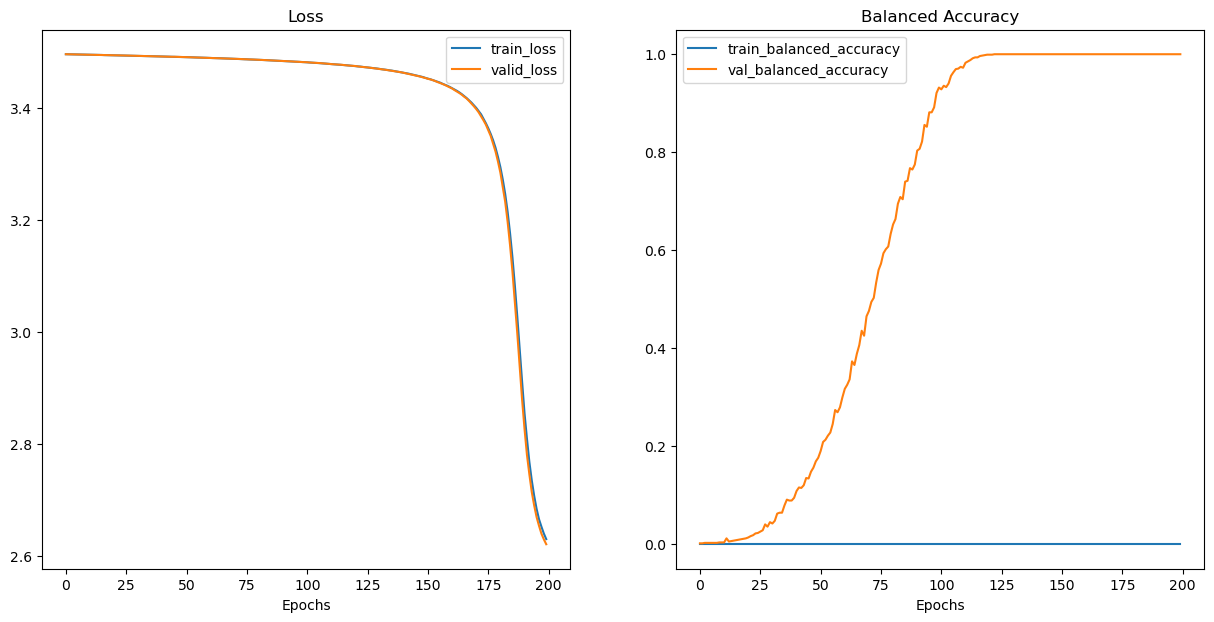

In [35]:
helper_functions.plot_loss_curves(results)
plt.savefig(f'All_TFs_CNN1_ADAM_BCEWithLogits_KERNEL=10_seq=200b.png')

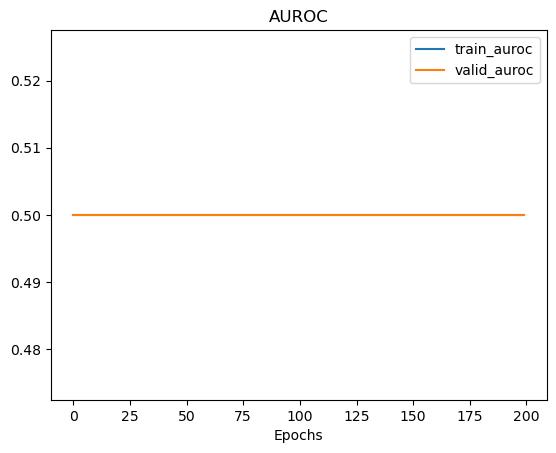

In [32]:
helper_functions.plot_auroc(results)

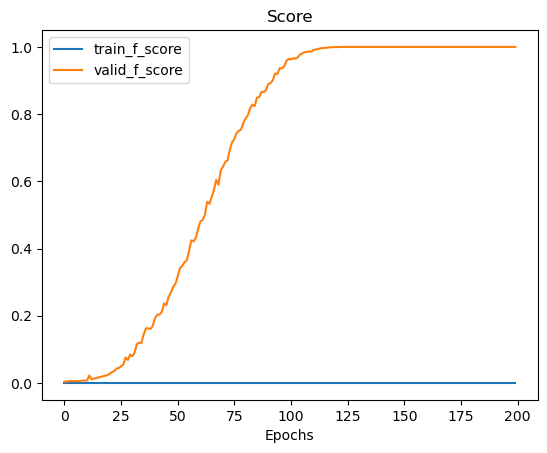

In [33]:
helper_functions.plot_f_score(results)

In [34]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
import torch.nn.functional as F


model.eval()


with torch.inference_mode():
    all_predictions = []
    all_true_labels = []
    all_test_pred_prob=[]
    
    test_loss, test_bal_acc, test_mcc, test_f_score = 0, 0, 0, 0
    for batch, (X, y_one_hot, y) in enumerate(test_loader):
        # Send data to target device
        X, y_one_hot, y = X.to(device),y_one_hot.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y_one_hot)
        test_loss += loss.item()

        # Calculate and accumulate scores
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_pred_prob = torch.softmax(test_pred_logits.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)
        test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')
        
        all_predictions.extend(test_pred_labels.cpu().numpy())
        all_true_labels.extend(y.cpu().numpy())
        all_test_pred_prob.extend(test_pred_prob.cpu().numpy())

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_loader)
    test_bal_acc = test_bal_acc / len(test_loader)
    test_mcc = test_mcc / len(test_loader)
    test_f_score = test_f_score / len(test_loader)
    print("Perfomance on held out test set")
    print(f'Test loss: {test_loss} | Test bal acc {test_bal_acc} | Test mcc {test_mcc} | Test_f_score {test_f_score}\n')   
    

ValueError: not enough values to unpack (expected 3, got 2)